# Preprocessing

In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import heapq
import re
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [3]:
df = pd.read_csv("train/train.csv")
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Feature Analysis

In [4]:
df['text_length'] = df["text"].apply(lambda x: len(x.split()))
author_names = df['author'].unique()
authors_df_list = []
word_summary = []
for author in author_names:
    author_df = df[df['author'] == author].rename(columns={'text_length' : f"{author}_text_length"})
    top_ten_word_counts = heapq.nlargest(10, author_df[f"{author}_text_length"])
    print(f"The highest 10 word counts from {author} were {top_ten_word_counts}.")
    authors_df_list.append(author_df)
    word_summary.append(author_df[f"{author}_text_length"].describe())
word_summary_df = pd.concat(word_summary, axis=1)
word_summary_df

The highest 10 word counts from EAP were [267, 256, 169, 164, 157, 149, 148, 148, 140, 137].
The highest 10 word counts from HPL were [147, 134, 117, 113, 113, 108, 102, 102, 100, 99].
The highest 10 word counts from MWS were [861, 594, 445, 377, 335, 191, 190, 186, 186, 181].


,EAP_text_length,HPL_text_length,MWS_text_length
count,7900.000000,5635.000000,6044.000000
mean,25.442405,27.799645,27.417273
std,18.567706,14.123252,23.134440
min,2.000000,4.000000,2.000000
25%,12.000000,18.000000,15.000000
50%,21.000000,26.000000,23.000000
75%,33.000000,35.000000,34.000000
max,267.000000,147.000000,861.000000


In [5]:
max_word_count = 200
for i, author in enumerate(author_names):
    initial_count = len(authors_df_list[i])
    authors_df_list[i] = authors_df_list[i][authors_df_list[i][f'{author}_text_length'] <= max_word_count]
    print(f"{author} had {initial_count - len(authors_df_list[i])} texts with more than {max_word_count} words. ")
df = df[df['text_length'] <= max_word_count]

EAP had 2 texts with more than 200 words. 
HPL had 0 texts with more than 200 words. 
MWS had 5 texts with more than 200 words. 


It is important to note that most of these samples fall within the range of 200. This means that we should remove the 9 entries (2 from EAP and 7 from MWS) that have more than 200 entries and consider them outliers. While a more strict boundary may be chosen, one must remember the importance of not "overfitting by hand". Choosing a loose boundary that only gets rid of large outlier helps improve generalizability. 

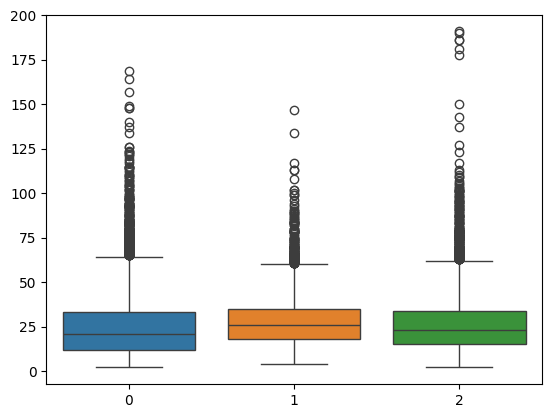

In [6]:
#TODO: rename below variable
word_list = []
for i, author in enumerate(author_names):
    word_list.append(authors_df_list[i][f"{author}_text_length"].values)
_ = sns.boxplot(data=word_list)

# Remove the text_length column as it is no longer needed
df.drop(columns=['text_length'], inplace=True)

## Preprocessing

In [7]:
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler

def bag_of_words(df) :
    labels = df["author"]
    df = df.drop(columns=["id", "author"])

    # Remove punctuation
    to_remove = ['.', ',', '?', '!', ':', ';']
    replacement = " "

    pattern = "|".join(map(re.escape, to_remove))
    df["text"] = df["text"].str.replace(pattern, replacement, regex=True)

    # Tokenization
    vectorizer = CountVectorizer(lowercase=True, binary=True, stop_words='english') # Binary makes values 0/1
    X = vectorizer.fit_transform(df["text"])
    
    normalizer = MaxAbsScaler()
    X = normalizer.fit_transform(X)
    print(X.shape)

    return X, labels

csr_matrix, labels = bag_of_words(df)
labelEncoder = OneHotEncoder(sparse_output=False)
labels = labelEncoder.fit_transform(pd.DataFrame(labels))

# Store the number of features
num_features = csr_matrix.shape[1]

(19572, 24719)


In [21]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# 70-20-10 split
train_val_test_split = [0.7, 0.2, 0.1]

X = torch.sparse_coo_tensor(csr_matrix.nonzero(), np.array(csr_matrix.data), csr_matrix.shape, dtype=torch.float, device=device)
y = torch.tensor(labels, device=device)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True, drop_last=True)

train_dataloader, val_dataloader, test_dataloader = random_split(dataset, train_val_test_split)

# Model Definition

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch 
from tqdm import tqdm
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(num_features, 8, dtype=torch.float)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(8, 3, dtype=torch.float)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x
    
    def mini_batch(self, train: bool, dataloader : DataLoader, optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss) -> float:
        running_loss = 0
        if(train):
            self.train(True)
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
        else:
            self.train(False)
            for X_batch, y_batch in dataloader:
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)

                running_loss += loss.item()
        average_loss = running_loss/len(dataloader)
        return average_loss

In [ ]:
# Create an instance of the network
model = LinearModel()
model = model.to(device=device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
train_losses = []
val_losses = []
epochs = range(1, num_epochs+1)
try:
    for epoch in tqdm(epochs):
        train = True
        train_loss = model.mini_batch(train=train, dataloader=train_dataloader, optimizer=optimizer, criterion=criterion)
        train = False
        val_loss = model.mini_batch(train=train, dataloader=val_dataloader, optimizer=optimizer, criterion=criterion)
        print(f"The training loss was: {train_loss} and the validation loss was: {val_loss}.")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except:
    np.save("train_losses.npy", np.array(train_losses))
    np.save("val_losses.npy", np.array(val_losses))
    torch.save(model.state_dict(), "linear_model.pt")
# model.save("linear_model.pt")
# Save Model
np.save("train_losses.npy", np.array(train_losses))
np.save("val_losses.npy", np.array(val_losses))
torch.save(model.state_dict(), "linear_model.pt")

  5%|▌         | 1/20 [00:46<14:35, 46.09s/it]

The training loss was: 1.0530745646915038 and the validation loss was: 0.9748083184462271.


 10%|█         | 2/20 [01:32<13:51, 46.17s/it]

The training loss was: 0.9071482634460737 and the validation loss was: 0.8173369784869433.


 15%|█▌        | 3/20 [02:17<12:57, 45.75s/it]

The training loss was: 0.7749572812706682 and the validation loss was: 0.7051492160520249.


 20%|██        | 4/20 [03:03<12:14, 45.91s/it]

The training loss was: 0.6934668112487292 and the validation loss was: 0.6355054809718684.


 25%|██▌       | 5/20 [03:50<11:34, 46.27s/it]

The training loss was: 0.6336236361691323 and the validation loss was: 0.5899366952009863.


 30%|███       | 6/20 [04:36<10:46, 46.16s/it]

The training loss was: 0.5859242965234631 and the validation loss was: 0.5568501697484902.


 35%|███▌      | 7/20 [05:23<10:01, 46.27s/it]

The training loss was: 0.5545997276491883 and the validation loss was: 0.5329023428704642.


 40%|████      | 8/20 [06:09<09:14, 46.24s/it]

The training loss was: 0.5288473675153786 and the validation loss was: 0.5166786665263823.


 45%|████▌     | 9/20 [06:55<08:27, 46.17s/it]

The training loss was: 0.49936602900444527 and the validation loss was: 0.5030534295574457.


 50%|█████     | 10/20 [07:41<07:41, 46.20s/it]

The training loss was: 0.4860530436483722 and the validation loss was: 0.4958705836435413.


 55%|█████▌    | 11/20 [08:26<06:52, 45.86s/it]

The training loss was: 0.47490343940433166 and the validation loss was: 0.4908402733796064.


 60%|██████    | 12/20 [09:12<06:06, 45.82s/it]

The training loss was: 0.45983446385674615 and the validation loss was: 0.48644598236274034.


 65%|██████▌   | 13/20 [09:58<05:22, 46.05s/it]

The training loss was: 0.4480468824653476 and the validation loss was: 0.48347840670814174.


 70%|███████   | 14/20 [10:44<04:36, 46.04s/it]

The training loss was: 0.4387710278346228 and the validation loss was: 0.4816133350997919.


 75%|███████▌  | 15/20 [11:31<03:50, 46.11s/it]

The training loss was: 0.43020612675027736 and the validation loss was: 0.481120624934702.


 80%|████████  | 16/20 [12:17<03:04, 46.06s/it]

The training loss was: 0.42336629023257366 and the validation loss was: 0.47976991853504125.


 85%|████████▌ | 17/20 [13:03<02:18, 46.21s/it]

The training loss was: 0.41405138197865254 and the validation loss was: 0.48113183290753125.


 90%|█████████ | 18/20 [13:50<01:32, 46.27s/it]

The training loss was: 0.4097100425743324 and the validation loss was: 0.48292627882493644.


 95%|█████████▌| 19/20 [14:35<00:46, 46.05s/it]

The training loss was: 0.40176082468827357 and the validation loss was: 0.4843126402840757.


100%|██████████| 20/20 [15:22<00:00, 46.10s/it]

The training loss was: 0.40205130147561735 and the validation loss was: 0.4870411445401413.


(20,)


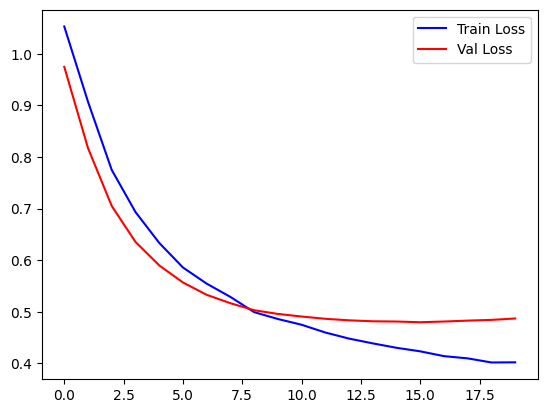

In [9]:
train_loss = np.load("train_losses.npy")
val_loss = np.load("val_losses.npy")
print(train_loss.shape)
epochs_trained = range(train_loss.shape[0])
_ = plt.plot(epochs_trained, train_loss, color='b', label="Train Loss")
_ = plt.plot(epochs_trained, val_loss, color='r', label="Val Loss")
_ = plt.legend()
plt.show()

## Run Model Against Test Data

In [32]:
model = LinearModel()
model.load_state_dict(torch.load("linear_model.pt", weights_only=True))

<All keys matched successfully>

## Confusion Matrix

[1 0 1 ... 0 2 2]
[1 0 1 ... 0 2 2]


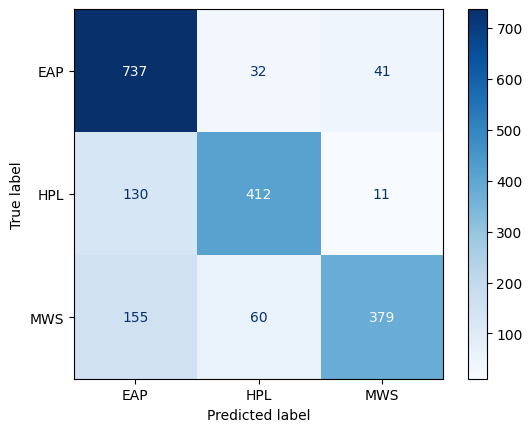

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
y_pred = []
y_actual = []
for X_batch, y_batch in test_dataloader:
    outputs = model(X_batch.cpu().detach())
    y_actual.append(y_batch.cpu().detach().numpy())
    y_pred.append(np.array(np.round(outputs.cpu().detach().numpy()), dtype=int))
y_pred_encoded = np.zeros_like(y_pred)
y_pred = np.array(y_pred)
y_pred_encoded[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

# Get predicted index array
pred_index_arr = np.argmax(y_pred_encoded, axis=1)
print(pred_index_arr)

# Get actual index array
y_actual = np.array(y_actual)
actual_index_arr = np.argmax(y_actual, axis=1)
print(actual_index_arr)

cm = confusion_matrix(actual_index_arr, pred_index_arr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=author_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()